In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['user', 'date'])

In [3]:
#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

In [4]:
data['first_message'].describe()

count    269385.000000
mean          0.028550
std           0.166539
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: first_message, dtype: float64

In [5]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [6]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

#stream length per firt
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

#unique chatters per hour
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']


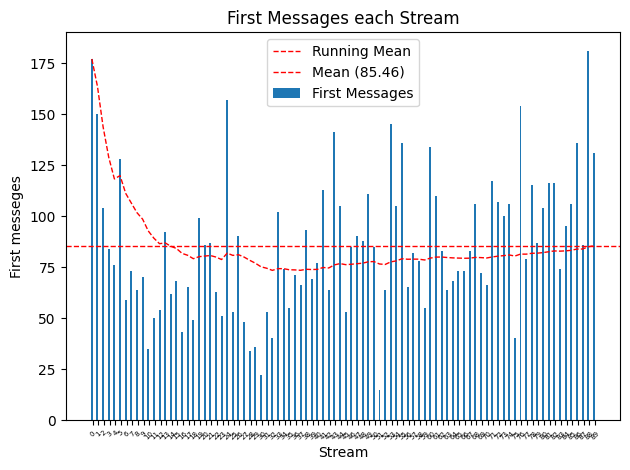

In [7]:
# Plot the chart
fig, ax = plt.subplots()

# Bar width
bar_width = 0.35

# Bar positions
index = range(len(stream_stats))

# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], bar_width, label='First Messages')

# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Labels and title
ax.set_xlabel('Stream', fontsize=10)
ax.set_ylabel('First messeges', fontsize=10)
ax.set_title('First Messages each Stream', fontsize=12)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stream_stats.index, fontsize=5)  # Adjust x-tick labels font size
ax.legend(fontsize=10)

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


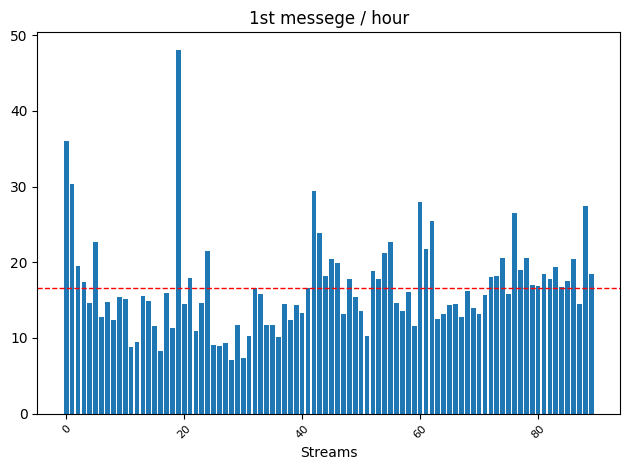

In [8]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['stream_length_per_firt'])

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].mean()

# Draw the mean line
ax.axhline(mean_stream_length_per_firt, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_length_per_firt:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_title('1st messege / hour', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

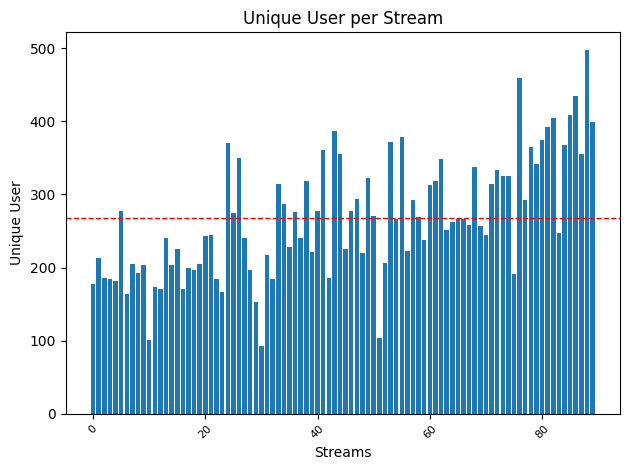

In [9]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters'])

# Calculate mean of first messages
mean_stream_unique = stream_stats['unique_chatters'].mean()

# Draw the mean line
ax.axhline(mean_stream_unique, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_unique:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User', fontsize=10)
ax.set_title('Unique User per Stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

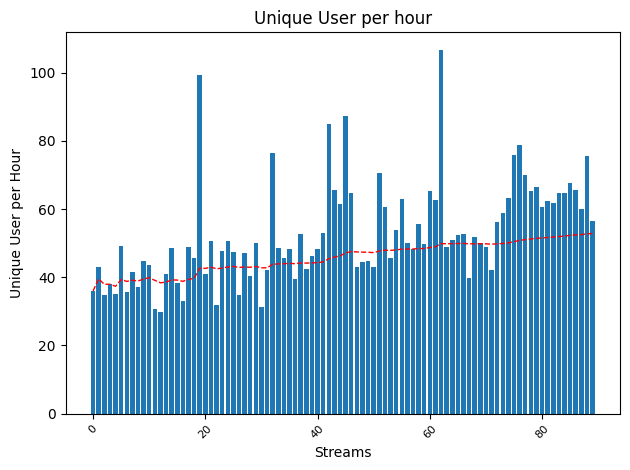

In [10]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters_per_hour'])

# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['unique_chatters_per_hour_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User per Hour', fontsize=10)
ax.set_title('Unique User per hour', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [11]:
# Group by stream and aggregate users
stream_users = data.groupby('stream')['user'].apply(set).reset_index()
stream_users.columns = ['stream', 'users']

# Initialize columns for returning users and their count
stream_users['returning_users'] = [set()] * len(stream_users)
stream_users['returning_count'] = 0

# Loop through streams to identify returning users
for i in range(1, len(stream_users)):
    current_users = stream_users.at[i, 'users']
    previous_users = stream_users.at[i - 1, 'users']
    
    # Identify returning users
    returning_users = current_users.intersection(previous_users)
    
    # Update dataframe with returning users and their count
    stream_users.at[i, 'returning_users'] = returning_users
    stream_users.at[i, 'returning_count'] = len(returning_users)

In [12]:
stream_stats = pd.merge(stream_stats, stream_users, on='stream', how='right')

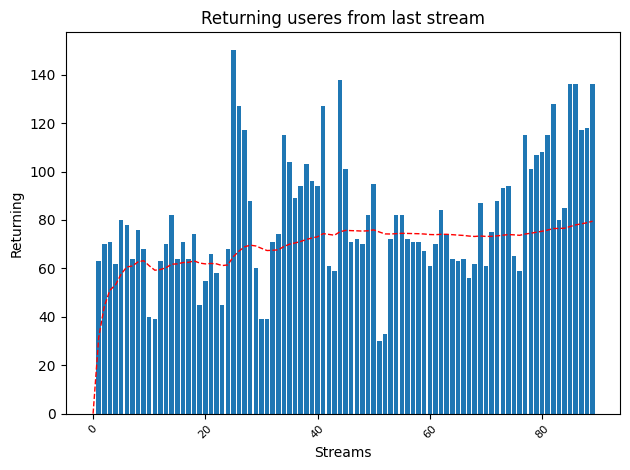

In [13]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['returning_count'])

# Calculate mean of first messages
stream_stats['returning_count_avg'] = stream_stats['returning_count'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['returning_count_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Returning', fontsize=10)
ax.set_title('Returning useres from last stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

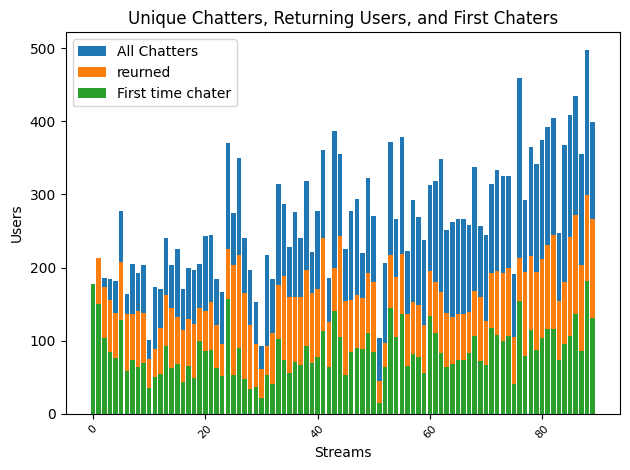

In [14]:
# Create a new column for the first-time chatters by subtracting returning_count from unique_chatters
stream_stats['grouped_return_first'] = stream_stats['returning_count'] + stream_stats['first_messages']

# Now plot the bars
fig, ax = plt.subplots()

# Bar plot for first-time chatters
ax.bar(stream_stats.index, stream_stats['unique_chatters'], label='All Chatters')

# Bar plot for first-time chatters
ax.bar(stream_stats.index, stream_stats['grouped_return_first'], label='reurned')

# Bar plot for first messages (stacked on top of the previous bars)
ax.bar(stream_stats.index, stream_stats['first_messages'], label='First time chater')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Users', fontsize=10)
ax.set_title('Unique Chatters, Returning Users, and First Chaters', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


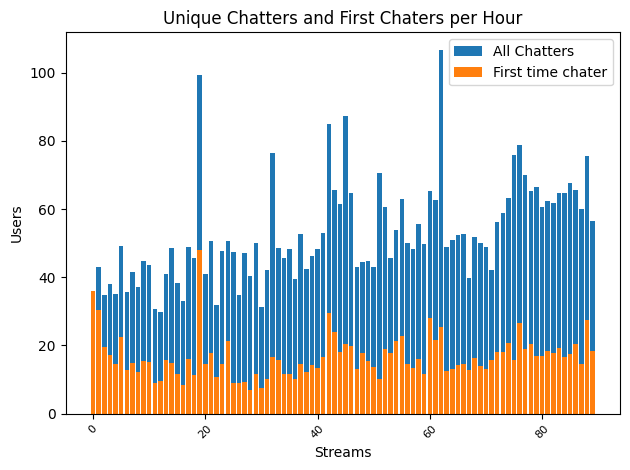

In [15]:
# Now plot the bars
fig, ax = plt.subplots()

# Bar plot for first-time chatters
ax.bar(stream_stats.index, stream_stats['unique_chatters_per_hour'], label='All Chatters')

# Bar plot for first messages (stacked on top of the previous bars)
ax.bar(stream_stats.index, stream_stats['stream_length_per_firt'], label='First time chater')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Users', fontsize=10)
ax.set_title('Unique Chatters and First Chaters per Hour', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


In [16]:
# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)

# Display the DataFrame
exelStats.head(2)

,stream,avg,max,follow,games
0,0,129,145,9,"jc, cs, valo, ow2, marbels"
1,1,152,290,24,"jc, cs, ow2, marbels"


In [17]:
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')


In [18]:
#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

In [19]:
#2 or more messeges
stream_stats['two_or_more_message_user_counts'] = stream_stats['unique_chatters'] - stream_stats['one_message_user_count']

In [20]:
#message per chater
stream_stats['message_per_chater'] = stream_stats['total_messages'] / stream_stats['unique_chatters']

In [21]:
#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

In [22]:
#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

In [23]:
#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


In [24]:
#No stream elements
dataNoBots = data[data['user'] != 'StreamElements']

In [25]:
# 1. Count the number of messages per user in each stream
user_message_counts = dataNoBots.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Find the top 5 users for each stream
top_5_users = user_message_counts.groupby('stream').apply(
    lambda x: x.nlargest(5, 'message_count')['user'].tolist()
).reset_index(name='top_5_users')

# Convert the list to a comma-separated string for easier viewing
top_5_users['top_5_users'] = top_5_users['top_5_users'].apply(lambda x: ', '.join(x))

# 3. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(top_5_users[['stream', 'top_5_users']], on='stream', how='left')



C:\Users\Kardo\AppData\Local\Temp\ipykernel_2280\877315785.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_users = user_message_counts.groupby('stream').apply(


In [26]:
for entry in stream_stats['top_5_users']:
    print(entry)

Martin_Gales, Banties1g, Jello_CS, 1206paul_, Wii_Gii
Martin_Gales, saykokerem, klimzaa, LX212, Banties1g
Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii
Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_
Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22, Banties1g
Martin_Gales, roxa0, Banties1g, IvanOnMyOwn, Risc__V
Martin_Gales, klimzaa, IvanOnMyOwn, peroni_nasturo_azuro, Risc__V
Martin_Gales, Banties1g, ylb_cat_soul22, Risc__V, 1SKELTON
Martin_Gales, Dmoz1, klimzaa, roxa0, Banties1g
oJov, roxa0, Ivana_10, IvanOnMyOwn, Martin_Gales
1SKELTON, zaxkyyy_, klimzaa, LX212, Banties1g
Martin_Gales, Banties1g, oJov, Typhu25, Krompus
LX212, amirmasoud_2018, 1SKELTON, klimzaa, Banties1g
oJov, Banties1g, klimzaa, LX212, abeKrd
Banties1g, oJov, LX212, 1SKELTON, IvanOnMyOwn
Martin_Gales, Dmoz1, I_Yovan_I, IvanOnMyOwn, LX212
Martin_Gales, sekasekas, ylb_cat_soul22, Banties1g, I_Yovan_I
oJov, Banties1g, Martin_Gales, sekasekas, IvanOnMyOwn
Martin_Gales, oJov, IvanOnMyOwn, roxa0, Dmoz1
Martin_Gales, roxa0,

In [27]:
#top 5 word in chat


# Define the list of words to exclude
stop_words = {'the',
                'a',
                'is',
                'to',
                'and',
                'i',
                'you',
                'in',
                'it',
                'u',
                'for',
                ']',
                'so',
                'on',
                'my',
                'are',
                'of',
                'this',
                'they',
                '/',
                'like',
                'have',
                'that',
                'its',
                '?',
                '!',
                'but',
                #maybe not
                'just',
                'was',
                'what',
                'your',
                'can',
                'not',
                'if',
                'she',
                'him',
                'we',
                'they',
                'at',
                'from',
                'by',
                'be',
                'he',
                'do'
                }

# 1. Tokenize messages by splitting them into words
#data['words'] = data['message'].apply(lambda x: x.split())

# Tokenize messages, splitting into words and filtering out stop words
dataNoBots = dataNoBots.copy()
dataNoBots['words'] = dataNoBots['message'].apply(lambda x: [word for word in x.split() if word.lower() not in stop_words])


# 2. Aggregate all words per stream
stream_words = dataNoBots.groupby('stream')['words'].sum().reset_index()

# 3. Calculate the top 5 most common words for each stream
stream_words['top_5_words'] = stream_words['words'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

# Convert list to a comma-separated string for easier viewing
stream_words['top_5_words'] = stream_words['top_5_words'].apply(lambda x: ', '.join(x))

# 4. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_words[['stream', 'top_5_words']], on='stream', how='left')


In [28]:
stream_stats['top_5_words'].tail(3)

87    !play, paul, doro, with, go
88    !play, doro, play, o7, good
89     doro, game, play, with, no
Name: top_5_words, dtype: object

In [29]:
for entry in stream_stats['top_5_words']:
    print(entry)

1, doro, !play, with, omE
sigma, doro, !play, mhm, with
mhm, !play, omE, doro, good
!play, mhm, doro, omE, LUL
mhm, doro, with, good, O?
mhm, setup, omE, !play, no
mhm, !play, peroni, doro, with
doro, with, mhm, when, me
peroni, !play, doro, mhm, no
LITHUANIA, good, song, no, #N1
LUL, mhm, how, omE, no
mhm, doro, no, game, omE
xd, !play, LUL, rameeKEK, omE
omE, hu, rameeKEK, with, !play
happy, happi, :D, am, !play
with, no, doro, good, yes
good, doro, with, mhm, play
doro, omE, with, raid, LUL
mhm, doro, with, good, cult
dimacut, RAID, raid, 󠀀, mhm
tier, mhm, good, omE, with
good, with, tier, dont, S
gkeyL, rameeKEK, raid, gamily, 100k
!play, doro, no, play, AIMindControlAttempt3
will, got, doro, omE, no
mhm, no, go, game, with
chair, mhm, doro, !play, no
@1206paul_, doro, mhm, good, with
PepeLaugh, no, mhm, doro, go
doro, K?, mhm, @1206paul_, im
TriHard, LETSGO, omE, doro, gg
bye, doro, mhm, good, her
doro, ding, play, up, LUL
dimacut, RAID, boss, Prayge, no
EZ, WW, gg, no, go
go, no,

In [30]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

unique_gifter = giftedData['user'].nunique()
print("Number of unique users:", unique_gifter)

Number of unique users: 74


In [31]:
unique_users_per_stream = giftedData.groupby('stream')['user'].nunique()

stream_stats = pd.merge(stream_stats, unique_users_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gifter'})
stream_stats['gifter'] = stream_stats['gifter'].fillna(0)

In [32]:
stream_stats['gifter'].describe()

count    90.000000
mean      1.322222
std       1.243661
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: gifter, dtype: float64

In [33]:
gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

In [34]:
primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

#stream_stats['prime'].describe()
stream_stats.head(5)


,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,two_or_more_message_user_counts,message_per_chater,hours_watched,total_word_count,message_per_min,top_5_users,top_5_words,gifter,gift,prime
0,0,177,1985,177,17697.0,4.915833,36.006103,36.006103,177.000000,36.006103,...,122,11.214689,634.142500,10568,6.729954,"Martin_Gales, Banties1g, Jello_CS, 1206paul_, ...","1, doro, !play, with, omE",4.0,25.0,2.0
1,1,150,3046,213,17831.0,4.953056,30.284336,43.003758,163.500000,39.504930,...,155,14.300469,752.864444,14301,10.249565,"Martin_Gales, saykokerem, klimzaa, LX212, Bant...","sigma, doro, !play, mhm, with",4.0,31.0,1.0
2,2,104,2754,185,19147.0,5.318611,19.553977,34.783517,143.666667,37.931126,...,133,14.886486,670.145000,13389,8.630073,"Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii","mhm, !play, omE, doro, good",0.0,0.0,2.0
3,3,84,2375,184,17451.0,4.847500,17.328520,37.957710,128.750000,37.937772,...,139,12.907609,644.717500,10244,8.165721,"Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_","!play, mhm, doro, omE, LUL",2.0,6.0,1.0
4,4,76,2455,182,18734.0,5.203889,14.604462,34.973844,118.200000,37.344986,...,120,13.489011,770.175556,11883,7.862710,"Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22,...","mhm, doro, with, good, O?",0.0,0.0,2.0


In [35]:
trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('raiders', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]

tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)


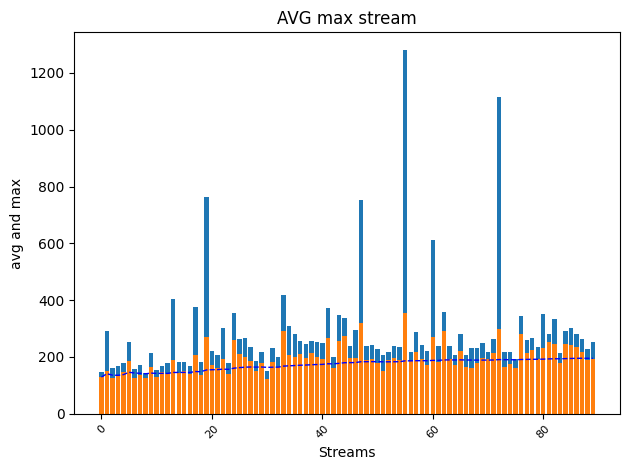

In [36]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['max'])

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])


# Calculate mean of first messages
stream_stats['epanding_avg'] = stream_stats['avg'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG max stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

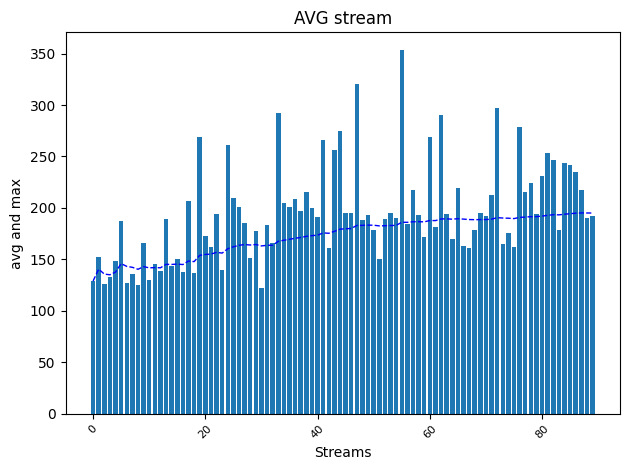

In [37]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

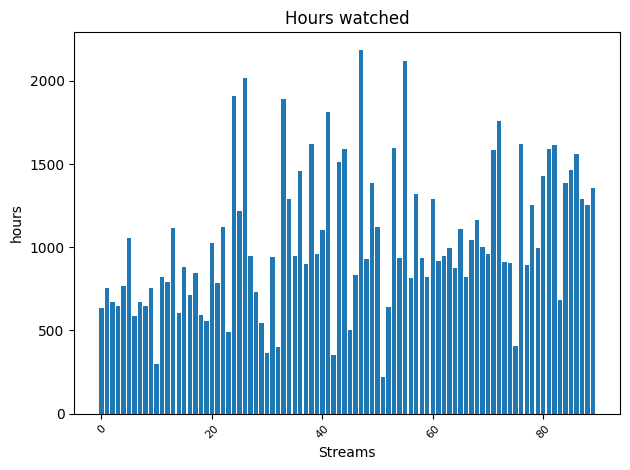

In [38]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['hours_watched'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Hours watched', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [39]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           90 non-null     int64  
 1   first_messages                   90 non-null     int64  
 2   total_messages                   90 non-null     int64  
 3   unique_chatters                  90 non-null     int64  
 4   stream_length                    90 non-null     float64
 5   stream_length_hour               90 non-null     float64
 6   stream_length_per_firt           90 non-null     float64
 7   unique_chatters_per_hour         90 non-null     float64
 8   first_messages_avg               90 non-null     float64
 9   unique_chatters_per_hour_avg     90 non-null     float64
 10  users                            90 non-null     object 
 11  returning_users                  90 non-null     object 
 12  returning_count         

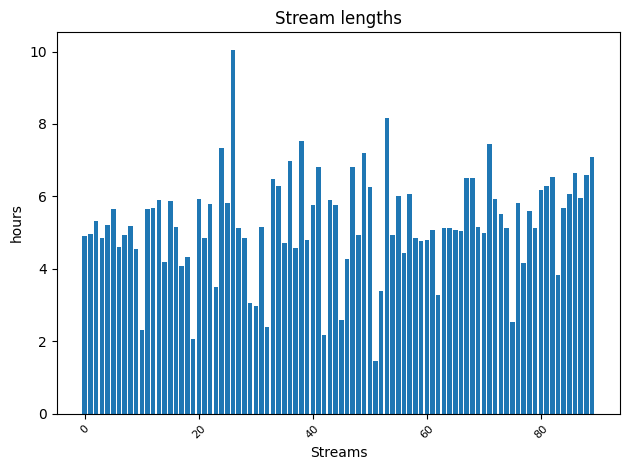

In [40]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['stream_length_hour'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Stream lengths', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [41]:

stream_stats.head(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,message_per_min,top_5_users,top_5_words,gifter,gift,prime,tier1,tier2,tier3,epanding_avg
0,0,177,1985,177,17697.0,4.915833,36.006103,36.006103,177.0,36.006103,...,6.729954,"Martin_Gales, Banties1g, Jello_CS, 1206paul_, ...","1, doro, !play, with, omE",4.0,25.0,2.0,3.0,0.0,0.0,129.0
1,1,150,3046,213,17831.0,4.953056,30.284336,43.003758,163.5,39.504930,...,10.249565,"Martin_Gales, saykokerem, klimzaa, LX212, Bant...","sigma, doro, !play, mhm, with",4.0,31.0,1.0,1.0,0.0,0.0,140.5


In [42]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,message_per_min,top_5_users,top_5_words,gifter,gift,prime,tier1,tier2,tier3,epanding_avg
88,88,181,4266,497,23717.0,6.588056,27.473964,75.439558,84.943820,52.753159,...,10.792259,"fyodor_m_d1821, Martin_Gales, Aloddin, balintb...","!play, doro, play, o7, good",1.0,10.0,10.0,14.0,0.0,0.0,195.056180
89,89,131,4021,399,25491.0,7.080833,18.500647,56.349300,85.455556,52.793116,...,9.464517,"fyodor_m_d1821, xXGenly_Top_AwpXx, sercanwinch...","doro, game, play, with, no",0.0,0.0,5.0,4.0,1.0,0.0,195.022222


In [43]:
#stream_stats.to_csv('combined_output.csv', index=False)

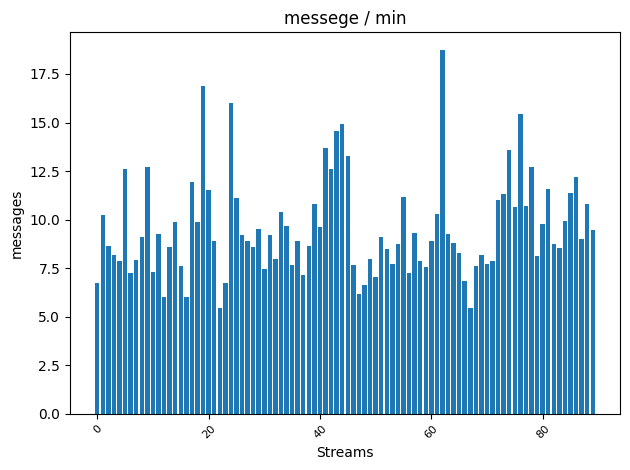

In [44]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['message_per_min'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('messages', fontsize=10)
ax.set_title('messege / min', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

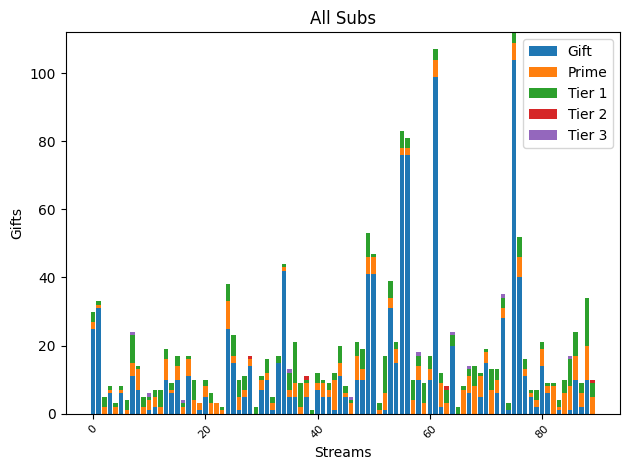

In [45]:
import matplotlib.pyplot as plt

# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['gift'], label='Gift')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['gift'], label='Prime')
ax.bar(stream_stats.index, stream_stats['tier1'], bottom=stream_stats['gift'] + stream_stats['prime'], label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'], label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'] + stream_stats['tier2'], label='Tier 3')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('All Subs', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


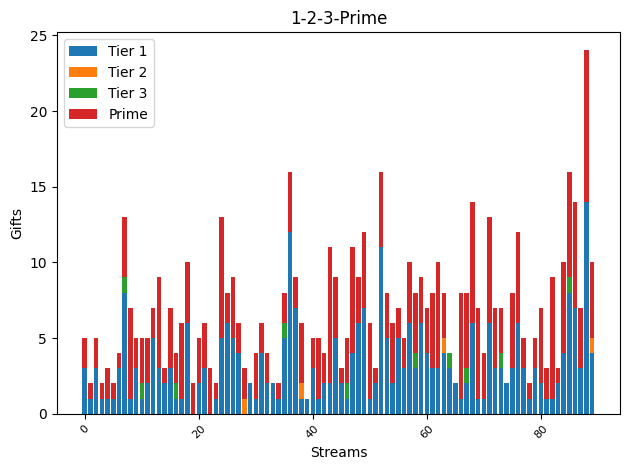

In [46]:
# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['tier1'], label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['tier1'], label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['tier1'] + stream_stats['tier2'], label='Tier 3')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'], label='Prime')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('1-2-3-Prime', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


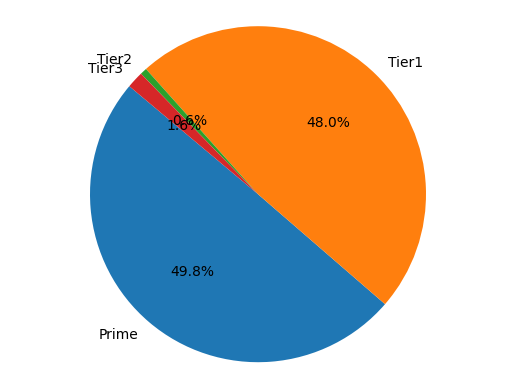

In [47]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


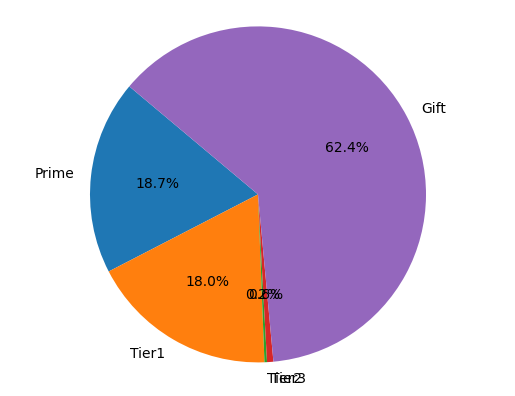

In [48]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3','Gift']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0],giftedData.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


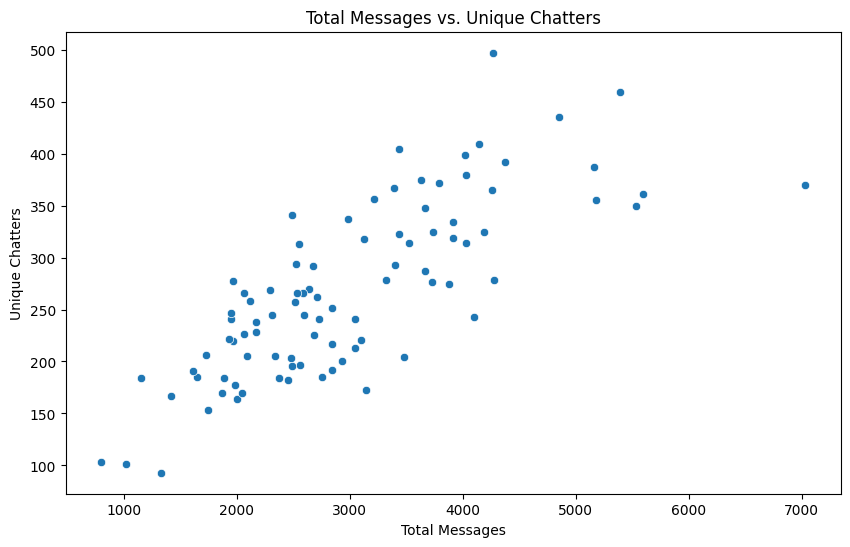

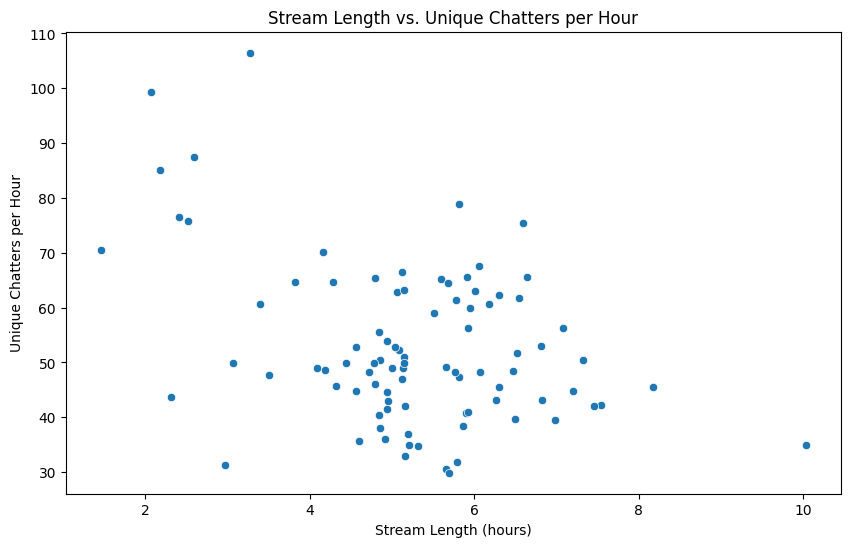

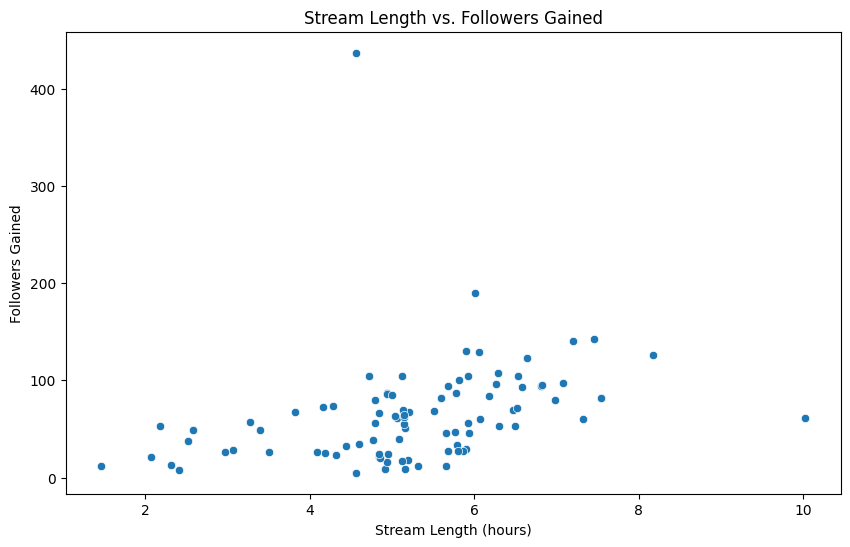

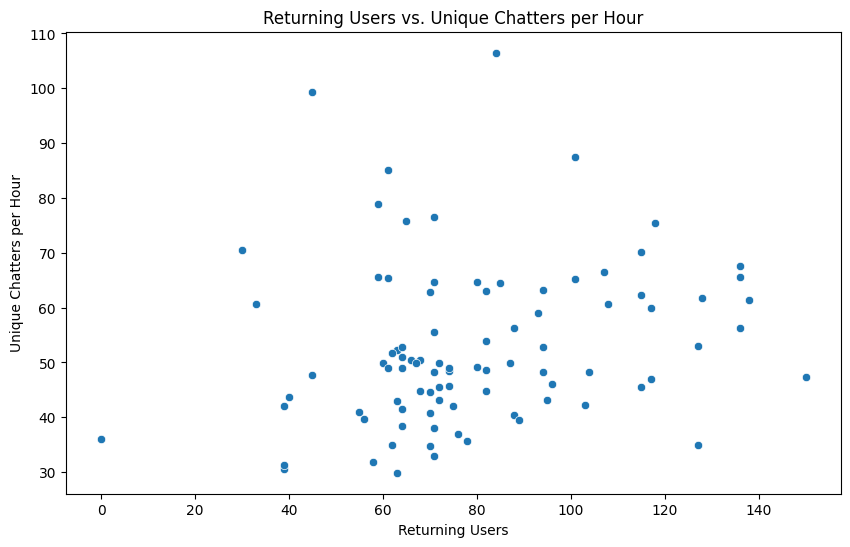

In [49]:

# Scatter plot for Total Messages vs. Unique Chatters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['total_messages'], y=stream_stats['unique_chatters'])
plt.title('Total Messages vs. Unique Chatters')
plt.xlabel('Total Messages')
plt.ylabel('Unique Chatters')
plt.show()

# Scatter plot for Stream Length vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Stream Length vs. Unique Chatters per Hour')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Unique Chatters per Hour')
plt.show()

# Scatter plot for Stream Length vs. Followers Gained
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['follow'])
plt.title('Stream Length vs. Followers Gained')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Followers Gained')
plt.show()

# Scatter plot for Returning Users vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['returning_count'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Returning Users vs. Unique Chatters per Hour')
plt.xlabel('Returning Users')
plt.ylabel('Unique Chatters per Hour')
plt.show()

In [50]:
# Split the 'games' column into lists
stream_stats['games_list'] = stream_stats['games'].str.split(', ')

# Get the unique games across all streams
unique_games = set(sum(stream_stats['games_list'].tolist(), []))- {''}

# Create a column for each unique game
for game in unique_games:
    stream_stats[game] = stream_stats['games_list'].apply(lambda x: 1 if game in x else 0)

# Drop the temporary 'games_list' column
stream_stats.drop(columns=['games_list'], inplace=True)


In [51]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           90 non-null     int64  
 1   first_messages                   90 non-null     int64  
 2   total_messages                   90 non-null     int64  
 3   unique_chatters                  90 non-null     int64  
 4   stream_length                    90 non-null     float64
 5   stream_length_hour               90 non-null     float64
 6   stream_length_per_firt           90 non-null     float64
 7   unique_chatters_per_hour         90 non-null     float64
 8   first_messages_avg               90 non-null     float64
 9   unique_chatters_per_hour_avg     90 non-null     float64
 10  users                            90 non-null     object 
 11  returning_users                  90 non-null     object 
 12  returning_count         

In [52]:
unique_games

{'chainedtogether',
 'cs',
 'deadatnigth',
 'er',
 'fortnite',
 'irl',
 'jc',
 'lol',
 'marbels',
 'mc',
 'ow2',
 'parasocial',
 'phazmo',
 'pubg',
 'rdr2',
 're2',
 're3',
 'roblox',
 'special',
 'valo'}

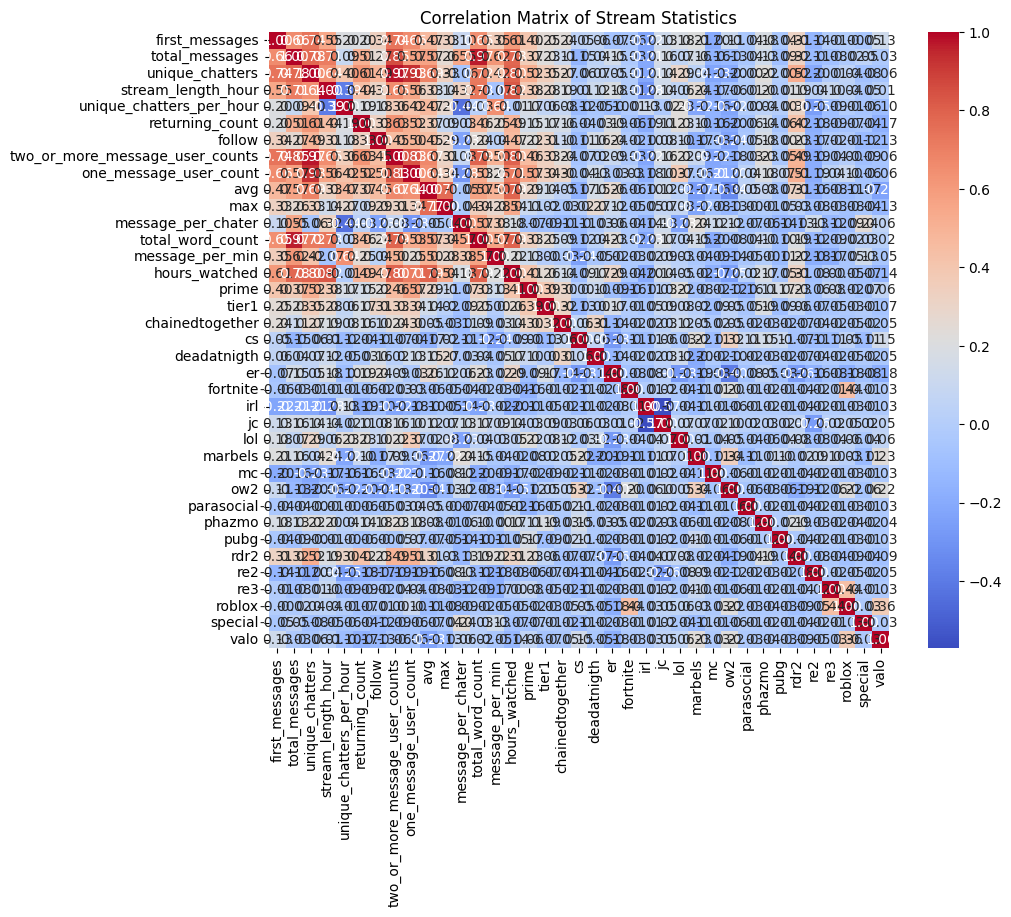

In [53]:
# Correlation matrix for selected columns
correlation_matrix = stream_stats[[ 'first_messages',
                                    'total_messages',
                                    'unique_chatters',
                                    'stream_length_hour',
                                    'unique_chatters_per_hour',
                                    'returning_count',
                                    'follow',
                                    'two_or_more_message_user_counts',
                                    'one_message_user_count',
                                    'avg',
                                    'max',
                                    'message_per_chater',
                                    'total_word_count',
                                    'message_per_min',
                                    'hours_watched',
                                    'prime',
                                    'tier1',
                                    'chainedtogether',
                                    'cs',
                                    'deadatnigth',
                                    'er',
                                    'fortnite',
                                    'irl',
                                    'jc',
                                    'lol',
                                    'marbels',
                                    'mc',
                                    'ow2',
                                    'parasocial',
                                    'phazmo',
                                    'pubg',
                                    'rdr2',
                                    're2',
                                    're3',
                                    'roblox',
                                    'special',
                                    'valo'
                                    ]].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stream Statistics')
plt.show()

In [54]:
#stream_stats.to_csv('combined_output.csv', index=False)

In [58]:
# Define game columns
game_columns = unique_games

# Initialize a dictionary to hold aggregated data
game_impact_data = {}

# Aggregate metrics for each game
for game in game_columns:
    # Filter the dataset for streams where the specific game was played
    game_data = stream_stats[stream_stats[game] == 1]
    
    # Calculate average metrics for the filtered data
    average_metrics = {
        'Average Total Messages': game_data['total_messages'].mean(),
        'Average Unique Chatters': game_data['unique_chatters'].mean(),
        'Average Hours Watched': game_data['hours_watched'].mean(),
        'Average Total Word Count': game_data['total_word_count'].mean(),
        'Average Returning User Count': game_data['returning_count_avg'].mean(),
        'Average Viewer Count': game_data['avg'].mean()
    }
    
    # Store the averages in the dictionary
    game_impact_data[game] = average_metrics

# Convert the dictionary to a DataFrame for better visualization
game_impact_df = pd.DataFrame(game_impact_data).T
game_impact_df.reset_index(inplace=True)
game_impact_df.columns = ['Game', 'Average Total Messages', 'Average Unique Chatters', 
                          'Average Hours Watched', 'Average Total Word Count', 
                          'Average Returning User Count','Average Viewer Count']



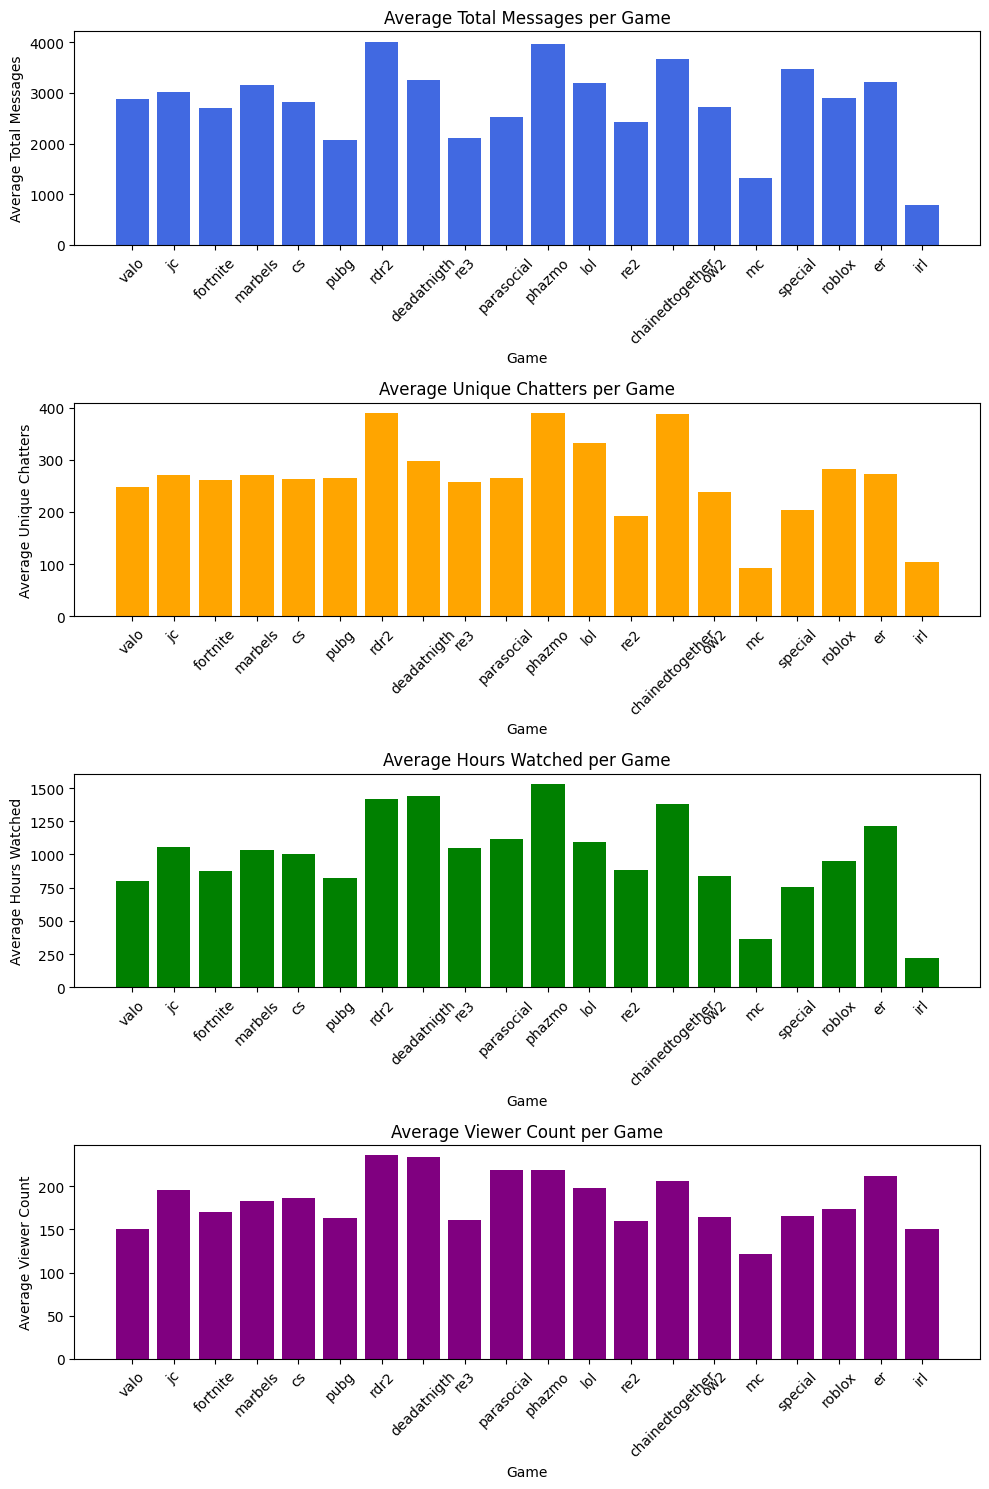

In [62]:
# Set up the figure and axes for subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

# Bar chart for Average Total Messages
ax[0].bar(game_impact_df['Game'], game_impact_df['Average Total Messages'], color='royalblue')
ax[0].set_title('Average Total Messages per Game')
ax[0].set_xlabel('Game')
ax[0].set_ylabel('Average Total Messages')
ax[0].tick_params(axis='x', rotation=45)

# Bar chart for Average Unique Chatters
ax[1].bar(game_impact_df['Game'], game_impact_df['Average Unique Chatters'], color='orange')
ax[1].set_title('Average Unique Chatters per Game')
ax[1].set_xlabel('Game')
ax[1].set_ylabel('Average Unique Chatters')
ax[1].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[2].bar(game_impact_df['Game'], game_impact_df['Average Hours Watched'], color='green')
ax[2].set_title('Average Hours Watched per Game')
ax[2].set_xlabel('Game')
ax[2].set_ylabel('Average Hours Watched')
ax[2].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[3].bar(game_impact_df['Game'], game_impact_df['Average Viewer Count'], color='purple')
ax[3].set_title('Average Viewer Count per Game')
ax[3].set_xlabel('Game')
ax[3].set_ylabel('Average Viewer Count')
ax[3].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()
